# Visualización de Información en Python

> **Autor** \
> Eduardo Graells-Garrido \
> Instituto de Data Science UDD \
> Telefónica I+D Chile \
> egraells@udd.cl \
> @carnby

## Sesión 3: Visualización de Datos Geográficos

> **Caso de Estudio** \
> Data Set: Encuesta de Viajes (Origen-Destino) de Santiago, 2012 \
> Data Set: [Mapas del Censo](http://www.censo2017.cl/servicio-de-mapas/), 2017 \
> Diplomado en Data Science UDD

## Introducción

En este notebook trabajaremos con información geográfica. Seguiremos estudiando el data set de viajes de la encuesta origen-destino, esta vez enfocándonos en distintos patrones geográficos que puedan ayudarnos a responder preguntas específicas.

### Lo que Haremos 

  1. Aprenderemos a cargar y procesar datos geográficos en formato shapefile, con la biblioteca `geopandas`.
  2. Aprenderemos a realizar _dot plots_.
  3. Aprenderemos a realizar _choropleth maps_.

### Preámbulo

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# incorporamos geopandas! geografía + pandas :)
import geopandas as gpd
from sklearn.preprocessing import normalize

%matplotlib inline
sns.set(context='notebook', font='Fira Sans', style='white', palette='plasma')

In [2]:
def decode_column(df, fname, col_name, index_col='Id', value_col=None, sep=';', encoding='utf-8', index_dtype=np.float64):
    '''
    param :df: DataFrame del que leeremos una columna.
    param :fname: nombre del archivo que contiene los valores a decodificar.
    param :col_name: nombre de la columna que queremos decodificar.
    param :index_col: nombre de la columna en el archivo @fname que tiene los índices que codifican @col_name
    param :value_col: nombre de la columna en el archivo @fname que tiene los valores decodificados
    param :sep: carácter que separa los valores en @fname. 
    param :encoding: identificación del _character set_ que utiliza el archivo. Usualmente es utf-8, si no funciona,
                     se puede probar con iso-8859-1.
    '''
    if value_col is None:
        value_col = 'value'
        
    values_df = pd.read_csv(fname, sep=sep, index_col=index_col, names=[index_col, value_col], header=0,
                            dtype={index_col: index_dtype}, encoding=encoding)
    
    src_df = df.loc[:,(col_name,)]
    
    return src_df.join(values_df, on=col_name)[value_col]

def normalize_rows(df):
    df = pd.DataFrame(normalize(df, norm='l1'), index=df.index, columns=df.columns)
    return df

def normalize_columns(df):
    df = pd.DataFrame(normalize(df, norm='l1', axis=0), index=df.index, columns=df.columns)
    return df

def z_score_columns(df):
    return df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

---

## Carga de Datos

Noten que ahora tenemos una variable `path_maps`, que contiene los ficheros con información geográfica en formato `shapefile`.

In [3]:
path = './EOD_STGO'

In [4]:
path_maps = './maps'

### Viajes

Primero, carguemos los datos que hemos trabajado en los notebooks anteriores.

In [5]:
viajes = (pd.read_csv(path + '/viajes.csv', sep=';', decimal=',', index_col='Viaje')
          .join(pd.read_csv(path + '/ViajesDifusion.csv', sep=';', index_col='Viaje'))
          .join(pd.read_csv(path + '/DistanciaViaje.csv', sep=';', index_col='Viaje')))

viajes['ModoDifusion'] = decode_column(viajes, path + '/Tablas_parametros/ModoDifusion.csv', 'ModoDifusion', encoding='latin-1',
                                       index_col='ID')
viajes['Proposito'] = decode_column(viajes, path + '/Tablas_parametros/Proposito.csv', col_name='Proposito')
viajes['SectorOrigen'] = decode_column(viajes, path + '/Tablas_parametros/Sector.csv', 
                                       col_name='SectorOrigen', index_col='Sector', value_col='Nombre', sep=';')
viajes['SectorDestino'] = decode_column(viajes, path + '/Tablas_parametros/Sector.csv', 
                                       col_name='SectorDestino', index_col='Sector', value_col='Nombre', sep=';')
viajes['ComunaOrigen'] = decode_column(viajes, path + '/Tablas_parametros/Comunas.csv', 'ComunaOrigen', 
                                       value_col='Comuna', sep=',')
viajes['ComunaDestino'] = decode_column(viajes, path + '/Tablas_parametros/Comunas.csv', 'ComunaDestino', 
                                       value_col='Comuna', sep=',')
viajes['Periodo'] = decode_column(viajes, path + '/Tablas_parametros/Periodo.csv', 'Periodo', 
                                  sep=';', value_col='Periodos')

# descartamos sectores que no sean relevantes en los orígenes y destinos de los viajes
viajes = viajes[(viajes['SectorOrigen'] != 'Exterior a RM') 
                & (viajes['SectorDestino'] != 'Exterior a RM')
                & (viajes['SectorOrigen'] != 'Extensión Sur-Poniente') 
                & (viajes['SectorDestino'] != 'Extensión Sur-Poniente')
                & pd.notnull(viajes['SectorOrigen'])
                & pd.notnull(viajes['SectorDestino'])
                # también descartamos viajes que hayan sido imputados en la encuesta
                & (viajes['Imputada'] == 0)
                # y finalmente descartamos viajes cuya distancia indique que son viajes cortísimos o bien demasiado largos para el tamaño de la ciudad
                & (viajes['DistManhattan'].between(500, 35000))]

print(len(viajes))

77383


Usaremos la misma codificación personalizada para los propósitos de viaje:

In [6]:
from collections import defaultdict

propositos_agregados = defaultdict(lambda: 'Otro')

propositos_agregados.update({
    'Al estudio': 'Estudio',
    'Al trabajo': 'Trabajo',
    'Por estudio': 'Estudio',
    'Por trabajo': 'Trabajo',
    'volver a casa': 'Volver a Casa',
    'De salud': 'Necesidades',
    'De compras': 'Necesidades',
    'Trámites': 'Necesidades'
})

viajes['PropositoAgregado'] = viajes['Proposito'].map(lambda x: propositos_agregados[x])

Cargamos la tabla de personas porque utilizaremos su factor de expansión:

In [7]:
personas = pd.read_csv(path + '/personas.csv', sep=';', decimal=',', encoding='utf-8')

In [8]:
viajes_persona = viajes.merge(personas)

In [9]:
viajes_persona['PesoLaboral'] = viajes_persona['FactorLaboralNormal'] * viajes_persona['Factor']

Así, el total de viajes que tenemos para un día laboral es:

In [10]:
print('{} viajes expandidos a {}'.format(len(viajes_persona), int(viajes_persona['PesoLaboral'].sum())))

77383 viajes expandidos a 8122419


### Geografía

Para datos geográficos trabajaremos con el formato `shapefile`. Se define así:

> El formato ESRI Shapefile (SHP) es un formato de archivo informático propietario de datos espaciales desarrollado por la compañía ESRI, quien crea y comercializa software para Sistemas de Información Geográfica como Arc/Info o ArcGIS. Originalmente se creó para la utilización con su producto ArcView GIS, pero actualmente se ha convertido en formato estándar de facto para el intercambio de información geográfica entre Sistemas de Información Geográfica por la importancia que los productos ESRI tienen en el mercado SIG y por estar muy bien documentado.
>
> Un shapefile es un formato vectorial de almacenamiento digital donde se guarda la localización de los elementos geográficos y los atributos asociados a ellos. No obstante carece de capacidad para almacenar información topológica. Es un formato multiarchivo, es decir está generado por varios ficheros informáticos. 
>
> -- [Wikipedia](https://es.wikipedia.org/wiki/Shapefile)

En general, los archivos `.shp` se almacenan en una carpeta donde otros archivos complementarios a la geografía tienen el mismo nombre pero con extensiones diferentes, por ejemplo, para almacenar meta-datos de la geografía.

#### Shapefile de la Encuesta Origen-Destino

La encuesta origen-destino disponibiliza un `shapefile` de las zonas de estudio en la [biblioteca](http://www.sectra.gob.cl/encuestas_movilidad/encuestas_movilidad.htm) de la SECTRA (Secretaría de Transporte). Sin embargo, el link está escondido en el código fuente de la página, ya que presenta problemas de rendering. Afortunadamente ya está en el repositorio del curso :)

Para cargar `shapefiles` podemos usar la función `read_file` de `geopandas`, entregando la carpeta donde esté nuestro archivo `.shp`. Si solamente hay un `.shp`, la biblioteca lo detecta automáticamente:

In [11]:
zonas_eod = gpd.read_file(path_maps + '/Zonificacion_EOD2012')
zonas_eod.head()

,ID,AREA,Zona,Com,Comuna,geometry
0,103,837.7500,103.0,13105,El Bosque,"POLYGON ((346376.6925730131 6286027.028697187,..."
1,104,998.8125,104.0,13105,El Bosque,"POLYGON ((344151.2352592435 6285465.039511388,..."
2,106,286.2500,106.0,13105,El Bosque,"POLYGON ((344415.4339754293 6285878.048256716,..."
3,115,857.4375,115.0,13105,El Bosque,"POLYGON ((344415.4339754293 6285878.048256716,..."
4,116,853.9375,116.0,13105,El Bosque,"POLYGON ((345133.4208225487 6286261.982521651,..."


Como ven, su apariencia es la de un `DataFrame`. Sin embargo, la columna `geometry` tiene un significado especial: contiene los elementos geográficos.

Adicionalmente, un `GeoDataFrame` tiene un método `plot` que se encarga de graficar los contenidos geográficos:

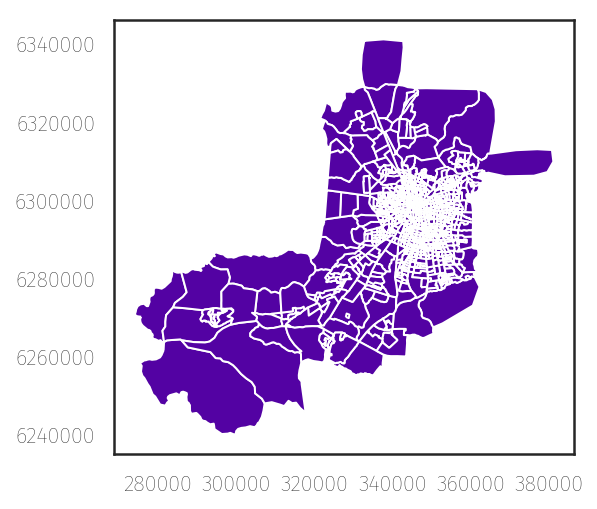

In [12]:
zonas_eod.plot()

El sistema de coordenadas utilizado por este fichero se puede ver con el atributo `crs` del `GeoDataFrame`:

In [13]:
zonas_eod.crs

{'init': 'epsg:32719'}

Aquí está la especificación del sistema de coordenadas [`EPSG:32719`](https://epsg.io/32719). Más adelante veremos que los archivos pueden tener sistemas de coordenadas distintos, pero que `geopandas` nos ayuda a trabajar con ello.

Un `GeoDataFrame` puede hacer las mismas operaciones que un `DataFrame` tradicional, incluyendo filtrado utilizando el operador `[]`. Aquí graficaremos las zonas para las cuales tenemos viajes en nuestra tabla de viajes. Noten que la columna `ID` del `GeoDataFrame` tiene (por definición) la misma codificación que las columnas `ZonaOrigen` y `ZonaDestino` de la tabla de viajes:

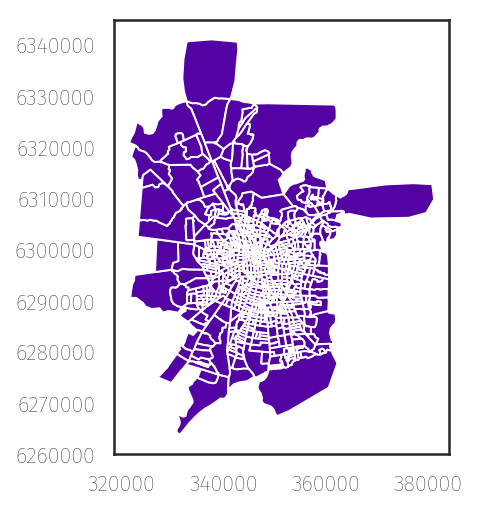

In [14]:
zonas_con_viajes = zonas_eod[zonas_eod.ID.isin(viajes.ZonaOrigen.unique())
                           & zonas_eod.ID.isin(viajes.ZonaDestino.unique())]
zonas_con_viajes.plot()

Tenemos menos zonas. Sin embargo, queda la sensación de que tenemos muchas zonas grandes correspondientes a zonas rurales que ocupan más espacio en el mapa que las zonas urbanas. Podemos mejorar esto utilizando datos del Censo 2017.

#### Shapefiles del Censo

El Censo 2017 disponibiliza una serie de `shapefiles` para cada región del país. En este caso, cargaremos un mapa para la Región Metropolitana (en la carpeta `R13`) con los límites urbanos definidos por el INE. Noten que en este caso le indicamos el nombre del archivo `.shp` a `geopandas`, debido a que la carpeta tiene otros ficheros `.shp`.

In [15]:
rm = gpd.read_file(path_maps + '/R13/LIMITE_URBANO_CENSAL_C17.shp')

In [16]:
rm.head()

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PAINE,CAPITAL COMUNAL,CIUDAD,0.146714,0.000531,POLYGON ((-70.73796863899997 -33.7985069579999...
1,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,HUELQUÉN,URBANO,PUEBLO,0.167916,0.000205,POLYGON ((-70.64840329599997 -33.8152110429999...
2,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,HOSPITAL,URBANO,CIUDAD,0.139694,0.000445,POLYGON ((-70.76467957199998 -33.8434912779999...
3,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PINTUÉ - LA GUACHERA,URBANO,PUEBLO,0.148207,0.000292,POLYGON ((-70.87823983099997 -33.8653966869999...
4,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,EL TRÁNSITO,URBANO,PUEBLO,0.073625,0.000066,POLYGON ((-70.65834050299998 -33.7835666779999...


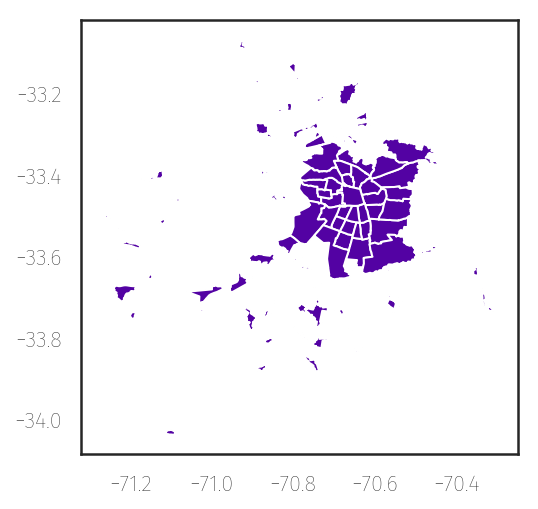

In [17]:
rm.plot()

Notamos que tiene una área geográfica por comuna. Sabemos que en Santiago hay tres provincias que nos interesan, así que nos gustaría tener un área por provincia (que podría tener varios polígonos, no necesariamente uno). Para ello podemos usar el método `dissolve` de `geopandas` de la siguiente manera:

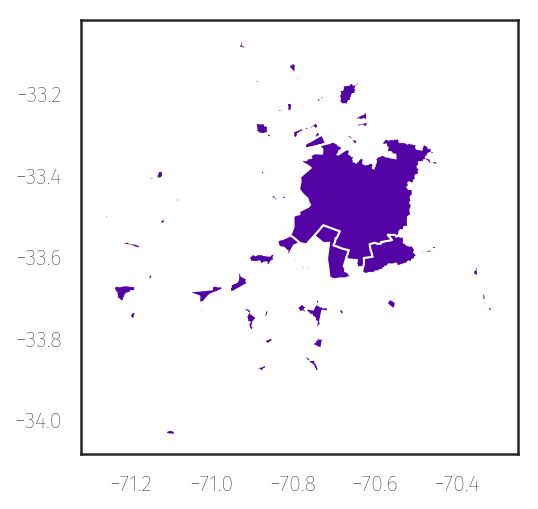

In [18]:
provincias = rm.dissolve(by='NOM_PROVIN')
provincias.plot()

In [19]:
provincias.head()

,geometry,REGION,NOM_REGION,PROVINCIA,COMUNA,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area
NOM_PROVIN,,,,,,,,,,,
CHACABUCO,(POLYGON ((-70.74271740299997 -33.271549461999...,13,REGIÓN METROPOLITANA DE SANTIAGO,133,13301,COLINA,COLINA,CAPITAL PROVINCIAL,CIUDAD,0.302769,0.001673
CORDILLERA,(POLYGON ((-70.56310183499994 -33.695434158999...,13,REGIÓN METROPOLITANA DE SANTIAGO,132,13201,PUENTE ALTO,PUENTE ALTO,CAPITAL PROVINCIAL,CIUDAD,0.477213,0.007370
MAIPO,(POLYGON ((-70.66200300999998 -33.894380304999...,13,REGIÓN METROPOLITANA DE SANTIAGO,134,13404,PAINE,PAINE,CAPITAL COMUNAL,CIUDAD,0.146714,0.000531
MELIPILLA,(POLYGON ((-71.09825806299995 -34.027436153999...,13,REGIÓN METROPOLITANA DE SANTIAGO,135,13504,MARÍA PINTO,MARÍA PINTO,CAPITAL COMUNAL,PUEBLO,0.046109,0.000112
SANTIAGO,(POLYGON ((-70.82700398699996 -33.509002240999...,13,REGIÓN METROPOLITANA DE SANTIAGO,131,13124,PUDAHUEL,LO AGUIRRE,URBANO,PUEBLO,0.048678,0.000102


Como ven, desaparecieron los bordes comunales, y la columna `NOM_PROVIN` define un índice en la tabla. Esto se debe a que el resultado es equivalente a hacer un `groupby` en `pandas`. Con el operador `.loc[]` de `pandas` (y por ende, `geopandas`) podemos elegir las filas del índice que nos interesan: 

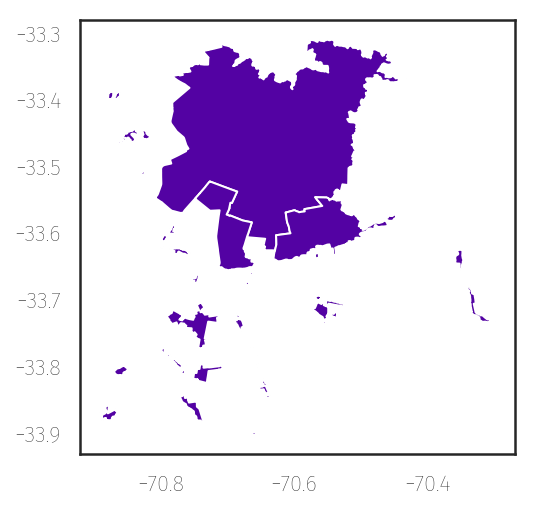

In [20]:
provincias = provincias.loc[['SANTIAGO', 'CORDILLERA', 'MAIPO']]
provincias.plot()

¡Mucho mejor! El siguiente paso es ver como podemos intersectar las zonas EOD que tenemos con estas áreas urbanas, de modo que las zonas que estén en los bordes urbanos se recorten y queden solamente con la sección urbana que les corresponda.

Para ello podemos usar la operación `overlay` de `geopandas`. Este método recibe dos `GeoDataFrame` y un nombre de operación. En este caso, diremos que queremos _intersectar_ con `zonas_con_viajes` y `rm`:

/home/egraells/anaconda3/envs/icochan/lib/python3.6/site-packages/geopandas/plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


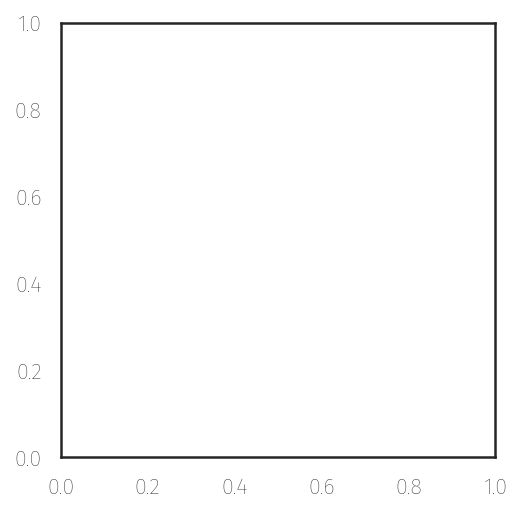

In [21]:
zonas_urbanas = gpd.overlay(zonas_con_viajes, rm, how='intersection')
zonas_urbanas.plot()

¡No pasó nada! 

Omitimos un paso crucial a la hora de trabajar con distintos `GeoDataFrames`: verificar que tengan el mismo sistema de coordenadas.

In [22]:
rm.crs

{'init': 'epsg:4674'}

No eran el mismo. Podemos usar el método `to_crs` de `geopandas` para cambiar el sistema de coordenadas de un `geodataframe`:

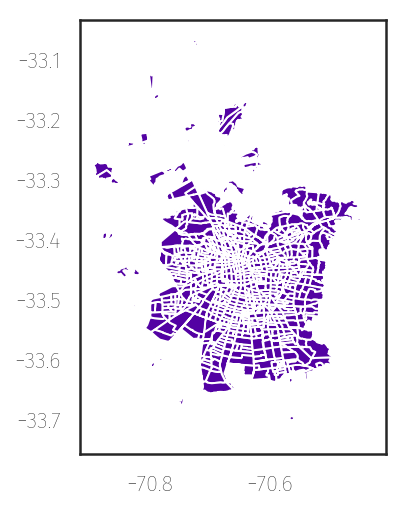

In [23]:
zonas_urbanas = gpd.overlay(zonas_con_viajes.to_crs(rm.crs), rm, how='intersection')
zonas_urbanas.plot()

¡Ahora sí! Tenemos las mismas zonas EOD de antes, pero en el sistema de coordenadas de `rm`, y considerando solamente las áreas urbanas definidas en el censo. Así quedó el `GeoDataFrame` final:

In [24]:
zonas_urbanas.head()

,ID,AREA,Zona,Com,Comuna,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area,geometry
0,103,837.7500,103.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,POLYGON ((-70.65484700000178 -33.5543640000007...
1,104,998.8125,104.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,POLYGON ((-70.67890900000191 -33.5591080000008...
2,106,286.2500,106.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,POLYGON ((-70.67599200000191 -33.5554230000007...
3,115,857.4375,115.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,POLYGON ((-70.67599200000191 -33.5554230000007...
4,116,853.9375,116.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,POLYGON ((-70.66819400000186 -33.5520660000007...


El siguiente paso es cambiarle el índice, eligiendo el atributo `ID` para ese fin. Esto nos permitirá cruzarlo con la tabla de viajes si es necesario.

In [25]:
zonas_urbanas = zonas_urbanas.set_index('ID')

En este punto, ya tenemos dos elementos que podemos utilizar para definir tareas:

- La tabla de viajes, cruzada con la tabla de personas.
- Geografía de Santiago utilizando la misma unidad de análisis espacial: zonas EOD.

Definamos _tareas_ o _preguntas a responder_ con estos datos.

---

## 1. ¿Cuál es la distribución geográfica de los viajes de acuerdo a la cantidad de combinaciones que realizan?

Para responder esta pregunta consideremos lo siguiente:

- Nos interesa particularmente el _origen_ de los viajes. Por ej., esperaríamos que una comuna más periférica tuviese viajes con más combinaciones que una comuna céntrica. La tabla de viajes contiene las columnas `OrigenCoordX` y `OrigenCoordY` que nos permitirán analizar este punto.
- Nos interesa el patrón geográfico de la distribución (no solamente saber que periférica => más combinaciones). Por tanto, necesitamos un mapa.
- La cantidad de combinaciones está implícitamente codificada en la variable `Etapas` de la tabla de viajes.

In [26]:
viajes_persona.columns

Index(['Hogar', 'Persona', 'Etapas', 'ComunaOrigen', 'ComunaDestino',
       'SectorOrigen', 'SectorDestino', 'ZonaOrigen', 'ZonaDestino',
       'OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY',
       'Proposito', 'PropositoAgregado', 'ActividadDestino', 'MediosUsados',
       'ModoAgregado', 'ModoPriPub', 'ModoMotor', 'HoraIni', 'HoraFin',
       'HoraMedia', 'TiempoViaje', 'TiempoMedio', 'Periodo', 'MinutosDespues',
       'CuadrasDespues', 'FactorLaboralNormal', 'FactorSabadoNormal',
       'FactorDomingoNormal', 'FactorLaboralEstival',
       'FactorFindesemanaEstival', 'CodigoTiempo', 'ModoDifusion',
       'DistEuclidiana', 'DistManhattan', 'Imputada', 'AnoNac', 'Sexo',
       'Relacion', 'Viajes', 'LicenciaConducir', 'PaseEscolar', 'AdultoMayor',
       'Estudios', 'Curso', 'Actividad', 'Ocupacion', 'ActividadEmpresa',
       'JornadaTrabajo', 'DondeEstudia', 'DirActividadCoordX',
       'DirActividadCoordY', 'DirEstudiosCoordX', 'DirEstudiosCoordY',
       'No

¿Cómo lucen las coordenadas?

In [27]:
viajes_persona[['OrigenCoordX', 'OrigenCoordY']].head()

,OrigenCoordX,OrigenCoordY
0,335208.7188,6288387.0
1,338812.2813,6292391.0
2,338536.4375,6291928.0
3,354267.3438,6302297.0
4,338536.4375,6291928.0


Si bien las coordenadas están en formato numérico, no sabemos en qué sistema de coordenadas están, ni tampoco las tenemos estructuradas en un `GeoDataFrame`. Para ello, usaremos la función `points_from_xy` de `geopandas` para darle contexto geográfico a los datos. Supondremos que las coordenadas están en el mismo sistema de referencia que el `shapefile` de zonas EOD.

In [28]:
origenes_viajes = gpd.GeoDataFrame(viajes_persona,
                                   geometry=gpd.points_from_xy(viajes_persona['OrigenCoordX'], viajes_persona['OrigenCoordY']),
                                   crs=zonas_eod.crs)
print(len(origenes_viajes))
origenes_viajes.head()

77383


,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,...,TramoIngresoFinal,IngresoImputado,Factor_LaboralNormal,Factor_SabadoNormal,Factor_DomingoNormal,Factor_LaboralEstival,Factor_FindesemanaEstival,Factor,PesoLaboral,geometry
0,173431,17343102,1,Maipú,Maipú,Poniente,Poniente,400,407,335208.7188,...,0,0,142.3375,NaN,NaN,NaN,NaN,53.39174,53.391740,POINT (335208.7188 6288387)
1,173431,17343102,1,Maipú,Maipú,Poniente,Poniente,407,400,338812.2813,...,0,0,142.3375,NaN,NaN,NaN,NaN,53.39174,53.391740,POINT (338812.2813 6292391)
2,173441,17344101,2,Maipú,Las Condes,Poniente,Oriente,407,307,338536.4375,...,2,0,112.9581,NaN,NaN,NaN,NaN,46.32137,52.214368,POINT (338536.4375 6291928)
3,173441,17344101,2,Las Condes,Maipú,Oriente,Poniente,307,407,354267.3438,...,2,0,112.9581,NaN,NaN,NaN,NaN,46.32137,52.214368,POINT (354267.3438 6302297)
4,173441,17344103,2,Maipú,Ñuñoa,Poniente,Oriente,407,437,338536.4375,...,2,1,103.5267,NaN,NaN,NaN,NaN,43.02566,48.499378,POINT (338536.4375 6291928)


Grafiquemos los orígenes de los viajes en conjunto con las zonas:

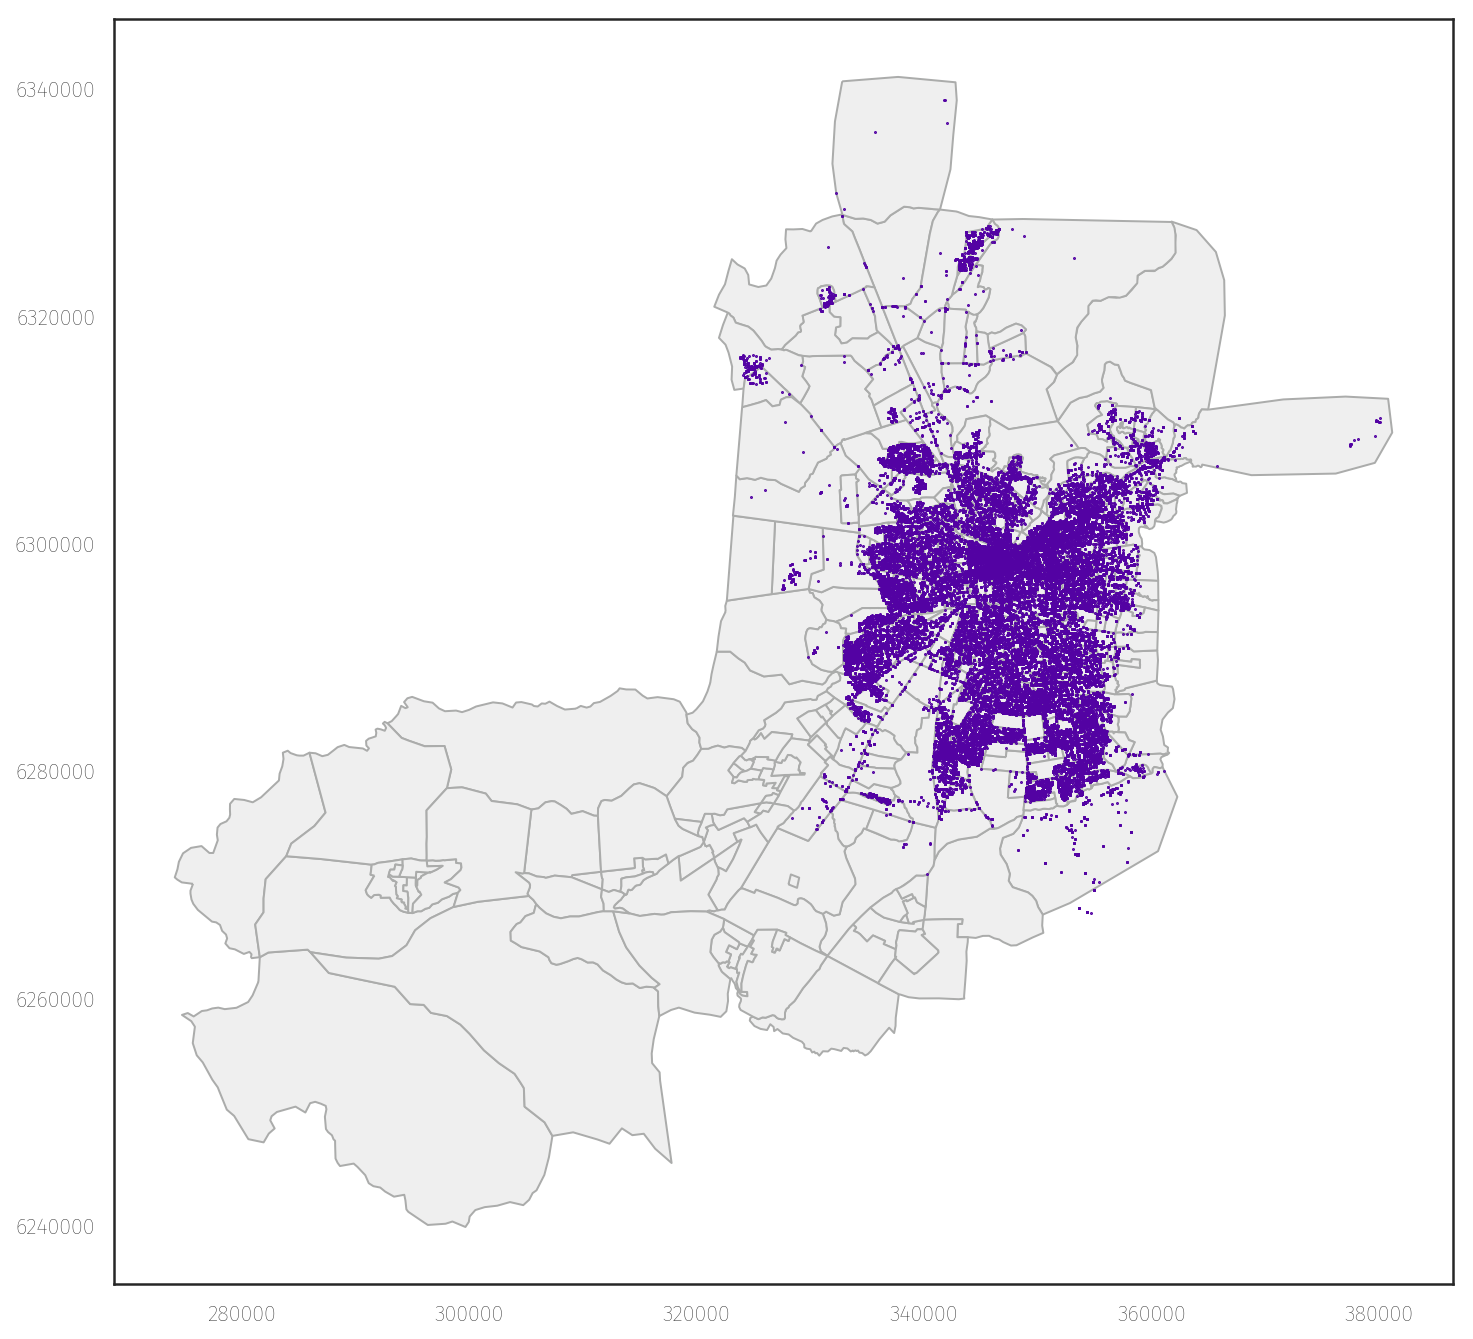

In [29]:
ax = zonas_eod.plot(figsize=(12, 12), color='#efefef', edgecolor='#abacab', linewidth=1)
origenes_viajes.plot(ax=ax, markersize=1, marker='.')

Vemos que hay viajes en sectores que no son relevantes para el análisis que queremos realizar, ya que están fuera del contexto urbano. Para seguir avanzando utilizaremos la operación _spatial join_ de `geopandas`, en el método `sjoin`. Un _spatial join_ cruza dos data sets desde una perspectiva espacial, a través de una operación definida. En nuestro caso, queremos los orígenes de viajes que estén dentro de las zonas urbanas. Esa operación en inglés es `within`. Se ejecuta de la siguiente manera:

In [ ]:
# nota: asegurarse que ambos GeoDataFrames tienen el mismo sistema de referencia
# los parámetros lsuffix y rsuffix indican el sufijo a agregar a las columnas de cada tabla
origenes_urbanos = gpd.sjoin(origenes_viajes.to_crs(zonas_urbanas.crs), 
                            zonas_urbanas, 
                            op='within', lsuffix='_l', rsuffix='_r')
print(len(origenes_urbanos))

Grafiquemos los orígenes de viajes urbanos al trabajo. Como estamos interesados en la distribución geográfica del número de etapas de los viajes, configuraremos el gráfico para que utilice esa columna (parámetro `column='Etapas'`). Lo trataremos como un atributo categórico ordinal (parámetro `categorical=True`):

In [ ]:
ax = zonas_urbanas.plot(figsize=(8, 10), color='#efefef', edgecolor='#abacab', linewidth=1)

origenes_a_graficar = origenes_urbanos[origenes_urbanos.PropositoAgregado == 'Trabajo']

(origenes_a_graficar
 .plot(categorical=True, 
       column='Etapas', 
       ax=ax, 
       marker='.', 
       markersize=10,  
       cmap='magma_r', 
       legend=True))

# no necesitamos ver las coordenadas
ax.set_axis_off()

A pesar de que estamos usando una paleta de colores que permite identificar el número de etapas de cada viaje, en el mapa cuesta ver una posible distribución geográfica debido a la oclusión y aglomeramiento de los viajes.

Una posible solución es darle un tamaño a cada punto que sea proporcional al peso de los viajes. Utilizaremos la función `minmax_scale` de `scikit-learn` para hacerlo:

In [ ]:
from sklearn.preprocessing import minmax_scale
origenes_urbanos['PesoVisual'] = minmax_scale(origenes_urbanos['PesoLaboral'], (0.01, 1.0))
origenes_urbanos['PesoVisual'].describe()

El peso visual mínimo de un viaje es $0.01$; el máximo, $1.00$ (son los parámetros que le entregamos a la función).
Esto hará que sea directo entregar un tamaño a `geopandas` para asignarle a cada punto. 

Por ejemplo, el código siguiente es idéntico al anterior, pero utilizando un nuevo parámetro: `markersize`. Como parámetro, recibe una columna del `GeoDataFrame`, en el que está el tamaño asignado a cada punto. Multiplicamos la columna por un número para que el tamaño tenga relación con las dimensiones de la imagen (es un parámetro que se ajusta manualmente a través de la exploración y re-ejecución del código). También agregamos un parámetro `alpha=0.75` que indica que cada punto se grafique con transparencia del $25%$, con el fin de disminuir el problema de la oclusión. 

In [ ]:
ax = zonas_urbanas.plot(figsize=(12, 12), color='#efefef', edgecolor='#abacab', linewidth=1)

origenes_a_graficar = origenes_urbanos[origenes_urbanos.PropositoAgregado == 'Trabajo']

(origenes_a_graficar
 .plot(categorical=True, 
       column='Etapas', 
       ax=ax, 
       marker='o', 
       markersize=origenes_a_graficar['PesoVisual'] * 500,  
       alpha=0.75,
       cmap='magma_r', 
       legend=True))

ax.set_axis_off()

En teoría, la idea sonaba bien, sin embargo, el gráfico no nos permite responder la pregunta (aunque es un lindo gráfico para compartir y contemplar). Esto se debe a varios factores, incluyendo la interferencia entre los canales utilizados en la codificación.

Una solución es utilizar múltiples gráficos, uno para cada valor de la categoría que nos interesa. Antes habíamos utilizado `FacetGrid` de `seaborn` para hacer una grilla de gráficos. Esta vez lo haremos manualmente utilizando las herramientas de `matplotlib`, a través de la función `subplots`:

In [ ]:
# ¿cuántas filas y columnas tendrá nuestra visualización?
n_columns = 2
n_rows = 2

# configuramos el tamaño de la figura (que contiene todos nuestros gráficos)
# los valores 6 y 9 han sido elegidos manualmente, prueben qué pasa si los cambian
figsize = (6 * n_columns, 9 * n_rows)

# crea la figura. cada gráfico corresponde a un elemento de la variable axes.
fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=figsize)
# axes es una matriz de 2x2. con esto la convertimos a una lista
# (esto facilitará el código siguiente, para iterar sobre ella)
axes = axes.flatten()

# aquí iteraremos sobre los ejes Y sobre el número de etapas
# range(1, 5) => [1, 2, 3, 4]
# el método zip nos permite iterar sobre dos listas simultáneamente
for ax, i in zip(axes, range(1, 5)):
    zonas_urbanas.plot(ax=ax, color='#efefef', edgecolor='#abacab', linewidth=0.5)
    ax.set_title('{} Etapa(s)'.format(i))
    
    # noten que agregamos un nuevo filtro: el número de etapas
    origenes_a_graficar = (origenes_urbanos
                          [(origenes_urbanos.PropositoAgregado == 'Trabajo') &
                           (origenes_urbanos.Etapas == i)])
    
    (origenes_a_graficar
     .plot(categorical=True, 
           ax=ax, 
           marker='o', 
           markersize=origenes_a_graficar['PesoVisual'] * 150,
           alpha=0.5,
           legend=False))
    
    ax.set_axis_off()
    
plt.subplots_adjust(wspace=0, hspace=0)

¡Mucho mejor! Queda claro no solamente la cantidad de viajes por cada etapa sino que también su distribución geográfica. Quizás podamos elegir una paleta de colores mejor y así diferenciar más los gráficos.

Para ello utilizaremos la función `color_palette` de `seaborn`. Le damos un nombre de un [mapa de colores](https://matplotlib.org/users/colormaps.html) y un número de colores:

In [ ]:
colors = sns.color_palette('magma_r', n_colors=4)
sns.palplot(colors)

La variable `colors` es una lista que contiene cada color, y podemos utilizarla en los parámetros que le entregamos a `geopandas.plot`:

In [ ]:
# cambiaremos la disposición del gráfico
n_columns = 4
n_rows = 1
figsize = (6 * n_columns, 9 * n_rows)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=figsize)
axes = axes.flatten()

# ¡noten que zip puede recibir más de una lista!
for ax, i, color in zip(axes, range(1, 5), colors):
    zonas_urbanas.plot(ax=ax, color='#efefef', edgecolor='#abacab', linewidth=0.5)
    
    origenes_a_graficar = (origenes_urbanos
                          [(origenes_urbanos.PropositoAgregado == 'Trabajo') &
                           (origenes_urbanos.Etapas == i)])
    
    # también cambiamos el título de cada gráfico para que sea más informativo
    ax.set_title('{} Etapa(s): {} Viajes'.format(i, int(origenes_a_graficar['PesoLaboral'].sum())))
    
    (origenes_a_graficar
     .plot(categorical=True, 
           ax=ax, 
           marker='o', 
           markersize=origenes_a_graficar['PesoVisual'] * 500,
           alpha=0.75,
           legend=False,
           edgecolor='black',
           linewidth=0.5,
           # usamos el parámetro color, al que le entregamos la variable color
           color=color))
    ax.set_axis_off()
    
plt.subplots_adjust(wspace=0, hspace=0)

Con esta configuración, cada columna de la grilla es un número de etapas. Un siguiente paso podría ser que cada fila tuviese significado. Por ejemplo, combinaciones de modo de transporte, o distancias de viaje. 

## 2. ¿Cuán lejos queda el trabajo de acuerdo al lugar de residencia?

Con esta pregunta queremos entender si existe un patrón geográfico en las elecciones de residencia y trabajo de las personas.

Para responder la pregunta, primero filtramos los viajes que nos interesan:

In [ ]:
viajes_trabajo = viajes_persona[(viajes_persona.PropositoAgregado == 'Trabajo') &
                                (pd.notnull(viajes_persona.PesoLaboral))]
print(len(viajes_trabajo), viajes_trabajo.PesoLaboral.sum())

Observamos que, si bien son 11642 filas en la tabla, representan a más de 1.7 millones de viajes.

La columna `DistEuclidiana` contiene la distancia entre los puntos de origen y destino de los viajes.

> **Nota**: no todos los viajes al trabajo se efectúan desde la casa, ni una persona hace un único viaje al trabajo durante el día.Pero omitiremos eso por el momento.

Veamos la distribución de la distancia:

In [ ]:
viajes_trabajo['DistEuclidiana'].describe()

Ahora bien, el promedio que nos entregó el método `pd.describe` no considera la representatividad de cada viaje. Podemos escribir una función que, dada una columna, calcula su representatividad, definiéndola como un promedio ponderado:

In [ ]:
def weighted_mean(df, value='DistEuclidiana', weight='PesoLaboral'):
    weighted_sum = (df[value] * df[weight]).sum()
    return weighted_sum / df[weight].sum()

weighted_mean(viajes_trabajo)

En este caso, el promedio ponderado no está lejos del promedio sin ponderar, pero nada asegura que esa diferencia sea pequeña para todas las variables.

Podemos calcular la distancia promedio al trabajo por zona haciendo una operación `pd.groupby`:

In [ ]:
distancia_zonas = viajes_trabajo.groupby(['ZonaOrigen']).apply(weighted_mean)
distancia_zonas

La variable `distancia_zonas` es una `Serie` de `pandas`. Cada columna de un `DataFrame` es una serie. Para poder hacer operaciones con ella, como cruzarla con un `DataFrame` a través del método `join`, necesita un nombre. Lo podemos asignar así:

In [ ]:
distancia_zonas.name = 'distancia_al_trabajo'

La serie contiene, para cada zona, la distancia promedio al trabajo de la gente que vive en ella (y posiblemente otras más). Si queremos ver esta distribución podemos utilizar el método `plot(kind='kde')`, como hicimos en notebooks anteriores:

In [ ]:
distancia_zonas.plot(kind='kde')
plt.xlim([0, distancia_zonas.max()])
plt.title('Distancia al Trabajo por Zonas')
plt.xlabel('Distancia')
plt.ylabel('Densidad (KDE)')
sns.despine()

Ahora bien, esta distribución solamente nos permite saber propiedades estádisticas. ¡No tenemos un contexto geográfico! Por eso necesitamos el mapa, para saber si la distancia tiene relación con la ubicación de cada zona en la ciudad, con saber si zonas que están cerca entre sí tienen distancias al trabajo similares.

Como tenemos los valores de distancia por zona, un _choropleth map_ nos permitiría mostrar la distancia asociada a cada zona al mismo tiempo que su posición geográfica. 

Lo haremos así:

- Haremos un `join` entre el `GeoDataFrame` `zonas_urbanas` y la `Serie` `distancia_zonas`. Le agregaremos el parámetro `how='inner'` que descartará aquellas zonas para las que no hay una distancia conocida.
- El `join` nos permite usar el parámetro `column='distancia_al_trabajo'.
- El color con el que se rellenará cada zona representará el quintil de la distribución de distancia en la que se encuentra esa zona. Esto lo logramos con los parámetros `scheme='Quintiles'` y `k=5` (si cambian `k` a 10, por ejemplo, tendrán deciles en vez de quintiles).

Se ve así:

In [ ]:
ax = zonas_urbanas.join(distancia_zonas, how='inner').plot(figsize=(9,12), 
                                              column='distancia_al_trabajo', 
                                              k=5,
                                              scheme='Quantiles',
                                              cmap='YlGnBu',
                                              edgecolor='#abacab',
                                              linewidth=0.5,
                                              legend=True)
plt.title('Quintiles de Distancia al Trabajo')
ax.set_axis_off()

La leyenda explica que valores más claros (es decir, los primeros quintiles) tienen menores distancias al trabajo. Al mismo tiempo, observamos la concentración de los trabajos en la ciudad: las zonas más claras tienden a aparecer en Santiago, Providencia, Las Condes, y sus alrededores. Como consecuencia, las zonas periféricas tienen una distancia al trabajo mayor: casi toda la periferia está compuesta de zonas oscuras.

¿Qué otro patrón observan en este mapa? ¿Qué más harían?

**¿Se imaginan este mapa mezclado con los mapas anteriores?** Ése es un ejercicio propuesto.

## 3. ¿Dónde se utiliza cada modo de transporte para viajes al trabajo?

Continuando la temática de viajes al trabajo, esta vez nos interesa saber dónde se utiliza cada modo de transporte. Por ejemplo, un sector que no tenga metro, seguramente no usará metro, pero, ¿se usa auto en lugares que tienen metro?¿Qué lugares de la ciudad se caracterizan por tener viajes en bicicleta?¿Dónde es mayoritario el uso de transporte público?

Primero, hagamos como en nuestra clase anterior: creemos una matriz donde las filas sean las zonas de la ciudad y las columnas sean los modos de transporte:

In [ ]:
viajes_por_modo = (viajes_persona
                   [viajes_persona.PropositoAgregado.isin(['Trabajo'])]
                   .groupby(['ZonaOrigen', 'ModoDifusion'])
                   .agg(n_viajes=('PesoLaboral', 'sum'))
                   ['n_viajes'].unstack(fill_value=0))
viajes_por_modo.head()

Una manera de responder el _dónde_ es identificando las zonas que están asociadas a cada modo de transporte. Al ser una matriz, podemos hacer lo siguiente:

- Normalizarla por filas, de modo que tengamos la distribución de viajes por zona.
- Utilizar un _sns.clustermap_ para agrupar zonas que tengan distribuciones similares.

In [ ]:
viajes_por_modo_normalizados = viajes_por_modo.pipe(normalize_rows)

# como tenemos más zonas que modos de transporte, transpondremos la matriz para que la visualización sea más ancha que alta
sns.clustermap(viajes_por_modo_normalizados.T, cmap='magma_r', figsize=(24, 9))

El resultado es interesante. Vemos que cada zona es una columna de la matriz (al estar transpuesta), que zonas parecidas aparecen juntas, y que también modos con distribuciones similares aparecen juntos. 

Eso nos dice que efectivamente hay zonas que se parecen mucho entre sí. Pero al mismo tiempo no nos dice cuáles son esas zonas, puesto que: 

1) no se pueden mostrar los números de todas las zonas (no caben en el gráfico);
2) no sabemos dónde está cada zona, su número no significa nada para nosotros.

Un mapa resolvería esas limitantes. Podemos hacer lo mismo del ejercicio anterior. Como podemos codificar una sola variable en el mapa, probemos viendo qué pasa si vemos un único modo en un mapa.

Al usar un mapa único por modo, lo que veremos en cada mapa es la distribución relativa del modo de viaje: es decir, para cada zona graficaremos la proporción de viajes _del total_ en ese modo.

In [ ]:
proporcion_por_zonas = viajes_por_modo.pipe(normalize_rows)
zonas_con_modo = zonas_urbanas.join(proporcion_por_zonas, how='inner')

Probemos con una paleta de colores secuencial:

In [ ]:
ax = zonas_con_modo.plot(figsize=(6, 9), column='Auto', cmap='Purples', legend=True, linewidth=0.5, 
                         edgecolor='#abacab', scheme='Quantiles', k=5)
ax.set_axis_off()

Se observa una mayor tendencia en el sector oriente, sin embargo, vemos que el uso del auto abarca casi todos los sectores de la ciudad.

Ahora hagamos un conjunto de mapas, uno por cada modo:

In [ ]:
n_columns = 3
# calculamos el número de filas automáticamente a partir del número de columnas
n_rows = int(np.ceil(len(viajes_por_modo.columns) / n_columns))
figsize = (4 * n_columns, 5 * n_rows)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=figsize)
axes = axes.flatten()

for ax, column in zip(axes, viajes_por_modo.columns):
    zonas_con_modo.plot(column=column, scheme='Quantiles', cmap='Purples', legend=False, ax=ax, edgecolor='#abacab', linewidth=0.5, k=5)
    ax.set_title(column)
    ax.set_axis_off()
    
# este código permite dejar en blanco los espacios de la grilla que no se utilizaron, en caso de ser necesario
for ax in axes[len(viajes_por_modo.columns):]:
    ax.set_visible(False)
    
plt.subplots_adjust(wspace=0, hspace=0)

Notamos que no siempre se puede realizar una desagregación en cinco categorías (por ejemplo, _Taxi_ y _Taxi Colectivo_). Sin embargo, estas distribuciones nos indican que efectivamente puede haber patrones geográficos en la distribución de uso de modo de viaje, ya que áreas con el mismo color tienden a aparecer juntas.

¿Qué patrones ven aquí? ¿Cómo interpretarían estos mapas?

---

## Conclusiones

Como ven, en ocasiones existen visualizaciones de tablas que permiten estudiar datos con atributos geográficos, sin embargo, los mapas nos entregan una riqueza contextual que no solamente permite hacer preguntas más profundas, sino que al mismo tiempo incita a hacer más preguntas a los datos. 

En este notebook utilizamos `geopandas` para hacer _dot maps_ y _choropleth maps_. Existen técnicas más avanzadas que veremos más adelante, no siempre disponibles en Python. Sin embargo, eso no significa que no usemos `geopandas`. Por ejemplo, un flujo común de trabajo es hacer análisis en `geopandas`, y luego exportar en formato `shapefile` o `GeoJSON` para ser visualizado en una herramienta interactiva (como `QGIS` o `Kepler.gl`).